# Accessing GEDI data using NASA Harmony API  



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


## Authenticate

In [24]:
from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import os
from IPython.display import JSON
import h5py
import pandas as pd
from shapely.geometry import Point

os.chdir('../../')

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials store in a .netrc file and allows users to type their credentials and persist them into a .netrc file if one does not exist. 

In [2]:
auth = earthaccess.login(persist=True)
# auth.token

To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object. 

In [3]:
harmony_client = Client(auth=(auth.username, auth.password)) 

## Get the GEDI Collections Harmoney Capabilities

Let us start by submitting a capabilities request to see the transformation supported in Harmony API using the GEDI product short names ('GEDI02_A', 'GEDI02_B', 'GEDI01_B'). Besides the `conceptId` and available variables, You can view the supported transformation services. Supported transformation services and variables (such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.) have `True` value. Based on the returned capabilities information for GEDI , we can submit a variable subsetting request, bounding box/shapefile subsetting, and temporal subsetting.

In [4]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_alg_count",
      "href": "h

## Create a Harmony Request

There are several parameters that can be used for the Harmoney request. see [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details. 


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository (CMR) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections. 

Below, `concept_id` is saved to a variable.  

In [5]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']


GEDI02_B , C2142776747-LPCLOUD


### GEDI Variable Subset

To learn more about the available layers, you can view the GEDI Dictionaries provided in [GEDI products' DOI Landing pages](https://lpdaac.usgs.gov/product_search/?query=gedi&status=Operational&view=cards&sort=title). The available GEDI datasets are also saved into a JSON file (`GEDI_Datasets.json`) stored in `data` folder and is used to view the available datasets here. 



In [6]:
with open('data/GEDI_Datasets.json', 'r') as fp:
    gedi_var = json.load(fp)

L2B = gedi_var['GEDI_L2B']
L2B[0:25]

['rx_processing/rg_eg_flag_a4',
 'rx_processing/rg_eg_gamma_error_a5',
 'rx_processing/rg_eg_gamma_error_a1',
 'rx_processing/rg_error_a3',
 'rx_processing/rg_eg_amplitude_a2',
 'geolocation/local_beam_elevation',
 'ancillary/rg_eg_constraint_center_buffer',
 'rx_processing/rx_energy_a6',
 'ancillary/tx_noise_stddev_multiplier',
 'pgap_theta_z',
 'rx_processing/rg_eg_center_error_a5',
 'rx_processing/pgap_theta_a4',
 'land_cover_data/modis_nonvegetated',
 'geolocation/longitude_bin0_error',
 'rx_processing/rg_error_a1',
 'geolocation/elev_highestreturn',
 'land_cover_data/landsat_water_persistence',
 'land_cover_data/leaf_on_doy',
 'rx_processing/algorithmrun_flag_a5',
 'geolocation/lon_lowestmode',
 'rx_processing/rx_energy_a4',
 'geolocation/digital_elevation_model',
 'rhov',
 'rx_processing/rg_a5',
 'rx_processing/rg_error_a2']

In [7]:
subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'lat_highestreturn', 'geolocation/lon_highestreturn', 'geolocation/elev_highestreturn', 'l2b_quality_flag', 'rh100', 'pai', 'pai_z', 'pavd_z']
# subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'rh100']

datasets_p = []
for s in subset_L2B:
    my_var = [v for v in L2B if v.endswith(f'{s}')]
    if len(my_var) == 1:
        datasets_p.append(my_var[0])
        
    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]
            
        for l in my_var:
            if l not in datasets_p:
                datasets_p.append(l) 

datasets_p

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/degrade_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/lat_highestreturn',
 'geolocation/lon_highestreturn',
 'geolocation/elev_highestreturn',
 'l2b_quality_flag',
 'rh100',
 'pai',
 'pai_z',
 'pavd_z']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [8]:
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']  #['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']


In [9]:
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in datasets_p]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/lat_highestreturn',
 '/BEAM0101/geolocation/lon_highestreturn',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/rh100',
 '/BEAM0101/pai',
 '/BEAM0101/pai_z',
 '/BEAM0101/pavd_z',
 '/BEAM0110/geolocation/lat_lowestmode',
 '/BEAM0110/geolocation/lon_lowestmode',
 '/BEAM0110/geolocation/degrade_flag',
 '/BEAM0110/geolocation/digital_elevation_model',
 '/BEAM0110/geolocation/elev_lowestmode',
 '/BEAM0110/geolocation/lat_highestreturn',
 '/BEAM0110/geolocation/lon_highestreturn',
 '/BEAM0110/geolocation/elev_highestreturn',
 '/BEAM0110/l2b_quality_flag',
 '/BEAM0110/rh100',
 '/BEAM0110/pai',
 '/BEAM0110/pai_z',
 '/BEAM0110/pavd_z',
 '/BEAM1000/geolocation/lat_lowestmode',
 '/BEAM1000/geolocation/lon_lowestmode',
 '/BEA

### Spatial Subset


Both `spaial` and` shape` are the query parameters used for spatial subsetting using bounding box and shapefile/GeoJSON respectively. For the Bounding box, the Harmony `Bbox` class accepts spatial coordinates as decimal degrees in the order of west, south, east, and north coordinates (e.g.(-119.205104, 36.012018, -117.907297, 37.054834)). For the spatial subset using a region of interest, the path to a GeoJSON file (.json or .geojson), an ESRI Shapefile (.zip or .shz), or a kml file (.kml) as `shape` param are acceptable inputs. 

In [10]:
## path to the GeoJSON
# roi ='data/sequoia.geojson'

# ## bounding box
# bound = gp.read_file('data/sequoia.geojson')['geometry'].bounds
# bound
roi = BBox(-119.205104, 36.012018, -117.907297, 37.054834)


### Temporal Subset

For temporal subsetting, the data temporal start and end ranges are used as a datetime object. Below, the start and end dates for the query are selected. 

In [11]:
temporal_range = {'start': datetime(2022, 4, 1), 
                  'stop': datetime(2022, 4, 20)}

Finally, submit the Harmony request and get the request ID.

In [12]:
request = Request(
    collection = Collection(id=concept_id),
    spatial = roi,    # for bbox
    # shape = roi,   # for the GeoJSON
    temporal = temporal_range,
    variables = subset
)

You can check the validity of the request before submitting a Harmony Request.

In [13]:
request.is_valid()

True

Finally, submit the request and retrieve list of the processed data URLs once processing is complete. You may optionally show the progress bar below.

In [14]:
task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)


Harmony request ID: 76fd8920-7920-4c65-9a2d-ed356be68570
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


Next, download the subset of data. 

In [15]:
results = harmony_client.download_all(task, directory='data', overwrite=True)


In [16]:
file_names = [f.result() for f in results]


data/GEDI02_B_2022096015510_O18768_03_T01108_02_003_01_V002_subsetted.h5
data/GEDI02_B_2022100001847_O18829_03_T05836_02_003_02_V002_subsetted.h5
data/GEDI02_B_2022108140620_O18962_02_T05036_02_003_01_V002_subsetted.h5
data/GEDI02_B_2022103224205_O18890_03_T06295_02_003_01_V002_subsetted.h5


Function is defined to create a dataframe from our HDF5 Harmony subset file. Next, `Geodataframe` is created for all the downloaded subset file. 

In [17]:
def h5_to_dataframe(ds, beams, vars):
    """
    This function takes Harmony subset of GEDI hdf5 and returns a dataframe. 
    """
    #read the dataset
    gedi_ds = h5py.File(ds,'r')
    # see what is the data product 
    product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
    fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
    date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
    # Create an empty DataFrame for this beam
    df_beam = pd.DataFrame(columns=vars)
    
    for b in beams:
        data_dic = {}
        for v in vars:
            # print(b,v)
            value = gedi_ds[f'{b}/{v}'][()]
            data_dic[v] = value.tolist() 
            
        df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")
        
        # add product, beam, file name, and date columns 
        df_beam.insert(0, 'product', product)
        df_beam.insert(1, 'Beam', b)
        df_beam.insert(2, 'fileName' , fileName)
        df_beam.insert(3, 'date', date)

    return(df_beam.reset_index(drop=True))


In [26]:
l2b_df = pd.DataFrame()

for file in file_names:
    print(file)
    gedi_subset = h5_to_dataframe(file, beams, datasets_p)
    l2b_df = gp.GeoDataFrame(pd.concat([l2b_df, gedi_subset]))
    del gedi_subset

# Reset the indeces
l2b_df = l2b_df.reset_index(drop=True)
l2b_df = l2b_df.rename(columns={'geolocation/lat_lowestmode': 'lat', 'geolocation/lon_lowestmode': 'lon'})
 # Take the lat/lon from dataframe and convert each lat/lon to a shapely point and convert to a Geodataframe
l2b_df = gp.GeoDataFrame(l2b_df, geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1))


data/GEDI02_B_2022096015510_O18768_03_T01108_02_003_01_V002_subsetted.h5
data/GEDI02_B_2022100001847_O18829_03_T05836_02_003_02_V002_subsetted.h5
data/GEDI02_B_2022108140620_O18962_02_T05036_02_003_01_V002_subsetted.h5
data/GEDI02_B_2022103224205_O18890_03_T06295_02_003_01_V002_subsetted.h5


In [27]:
l2b_df.head()

,product,Beam,fileName,date,lat,lon,geolocation/degrade_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/lat_highestreturn,geolocation/lon_highestreturn,geolocation/elev_highestreturn,l2b_quality_flag,rh100,pai,pai_z,pavd_z,geometry
0,GEDI_L2B,BEAM1011,GEDI02_B_2022096015510_O18768_03_T01108_02_003...,2022-04-06 01:55:10,36.370463,-119.204905,0,80.876175,80.814789,36.370460,-119.204902,86.911545,0,609,0.166375,"[0.16637547314167023, 0.013296562246978283, -0...","[0.030615782365202904, 0.016637546941637993, 0...",POINT (-119.20491 36.37046)
1,GEDI_L2B,BEAM1011,GEDI02_B_2022096015510_O18768_03_T01108_02_003...,2022-04-06 01:55:10,36.370122,-119.204431,0,82.102180,81.109215,36.370118,-119.204427,89.263161,1,814,0.272821,"[0.27282053232192993, 0.058773595839738846, -0...","[0.0428093858063221, 0.027282051742076874, 0.0...",POINT (-119.20443 36.37012)
2,GEDI_L2B,BEAM1011,GEDI02_B_2022096015510_O18768_03_T01108_02_003...,2022-04-06 01:55:10,36.369780,-119.203957,0,82.102180,81.093712,36.369779,-119.203955,84.572227,1,347,0.044619,"[0.044618964195251465, -0.0, -0.0, -0.0, -0.0,...","[0.008923793211579323, 0.004461896605789661, -...",POINT (-119.20396 36.36978)
3,GEDI_L2B,BEAM1011,GEDI02_B_2022096015510_O18768_03_T01108_02_003...,2022-04-06 01:55:10,36.369439,-119.203483,0,81.730209,81.244621,36.369437,-119.203480,86.144463,1,488,0.101626,"[0.10162646323442459, -0.0, -0.0, -0.0, -0.0, ...","[0.02032529190182686, 0.01016264595091343, -0....",POINT (-119.20348 36.36944)
4,GEDI_L2B,BEAM1011,GEDI02_B_2022096015510_O18768_03_T01108_02_003...,2022-04-06 01:55:10,36.369098,-119.203008,0,81.730209,81.397682,36.369095,-119.203005,87.718857,1,632,0.554650,"[0.5546496510505676, 0.006854844745248556, -0....","[0.10955896228551865, 0.055464968085289, 0.000...",POINT (-119.20301 36.36910)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
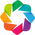

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (date)

In [28]:

from geoviews import opts, tile_sources as gvts
import geoviews
geoviews.extension('bokeh')

gvts.EsriImagery * geoviews.Points(l2b_df, vdims=['date']).options(tools=['hover'], 
                                                                   height=900, width=900, size=1, color='yellow', 
                                                                   fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'ylabel': 16})



## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 02-20-2024  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  